In [1]:
import copy
from pathlib import Path
import sys

import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

In [2]:
# create data directory if not exists
HERE = Path(_dh[-1])
DATA = HERE / "data"
DATA.mkdir(exist_ok=True)

In [3]:
pdbid = "3POZ"
ligand_name = "03P"
pdb_path = DATA / f"{pdbid}.pdb"
pdb_url = f"https://files.rcsb.org/download/{pdbid}.pdb"

In [4]:
r = requests.get(pdb_url)
r.raise_for_status()
with open(pdb_path, "wb") as f:
    f.write(r.content)

In [5]:
def prepare_protein(
    pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True, ph=7.0
):
    """
    Use pdbfixer to prepare the protein from a PDB file. Hetero atoms such as ligands are
    removed and non-standard residues replaced. Missing atoms to existing residues are added.
    Missing residues are ignored by default, but can be included.

    Parameters
    ----------
    pdb_file: pathlib.Path or str
        PDB file containing the system to simulate.
    ignore_missing_residues: bool, optional
        If missing residues should be ignored or built.
    ignore_terminal_missing_residues: bool, optional
        If missing residues at the beginning and the end of a chain should be ignored or built.
    ph: float, optional
        pH value used to determine protonation state of residues

    Returns
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
        Prepared protein system.
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # co-crystallized ligands are unknown to PDBFixer
    fixer.findMissingResidues()  # identify missing residues, needed for identification of missing atoms

    # if missing terminal residues shall be ignored, remove them from the dictionary
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]

    # if all missing residues shall be ignored ignored, clear the dictionary
    if ignore_missing_residues:
        fixer.missingResidues = {}

    fixer.findNonstandardResidues()  # find non-standard residue
    fixer.replaceNonstandardResidues()  # replace non-standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(ph)  # add missing hydrogens
    return fixer

In [6]:
# prepare protein and build only missing non-terminal residues
prepared_protein = prepare_protein(pdb_path, ignore_missing_residues=False)

In [7]:
def prepare_ligand(pdb_file, resname, smiles, depict=True):
    """
    Prepare a ligand from a PDB file via adding hydrogens and assigning bond orders. A depiction
    of the ligand before and after preparation is rendered in 2D to allow an inspection of the
    results. Huge thanks to @j-wags for the suggestion.

    Parameters
    ----------
    pdb_file: pathlib.PosixPath
       PDB file containing the ligand of interest.
    resname: str
        Three character residue name of the ligand.
    smiles : str
        SMILES string of the ligand informing about correct protonation and bond orders.
    depict: bool, optional
        show a 2D representation of the ligand

    Returns
    -------
    prepared_ligand: rdkit.Chem.rdchem.Mol
        Prepared ligand.
    """
    # split molecule
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file))
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # extract the ligand and remove any already present hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)

    # assign bond orders from template
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # protonate ligand
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    prepared_ligand = Chem.MolFromMolBlock(Chem.MolToMolBlock(prepared_ligand))

    # 2D depiction
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]
            )
        )

    # return ligand
    return prepared_ligand

[11:08:22] WARNING: More than one matching pattern found - picking one



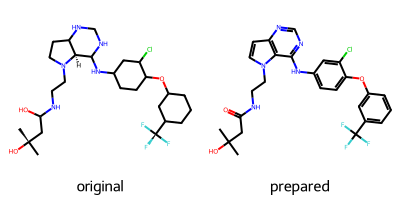

In [8]:
smiles = "CC(C)(O)CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc(c4)C(F)(F)F)c(Cl)c3)c12"
rdkit_ligand = prepare_ligand(pdb_path, ligand_name, smiles)

In [9]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.
    Inspired by @hannahbrucemcdonald and @glass-w.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.

    Returns
    -------
    omm_molecule: openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol)

    # add name for molecule
    off_mol.name = name

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # convert units from Ångström to nanometers
    # since OpenMM works in nm
    mol_positions = mol_positions.to("nanometers")

    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)

    return omm_mol

In [10]:
omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

In [11]:
def merge_protein_and_ligand(protein, ligand):
    """
    Merge two OpenMM objects.

    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: openmm.app.Modeller
        Ligand to merge.

    Returns
    -------
    complex_topology: openmm.app.topology.Topology
        The merged topology.
    complex_positions: openmm.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) :] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [12]:
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/openmm/unit/quantity.py:753: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._value[key] = value / self.unit


In [13]:
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
# NBVAL_CHECK_OUTPUT

Complex topology has 5561 atoms.


In [14]:
def generate_forcefield(
    rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"
):
    """
    Generate an OpenMM Forcefield object and register a small molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in the force field.
    protein_ff: string
        Name of the force field.
    solvent_ff: string
        Name of the solvent force field.

    Returns
    -------
    forcefield: openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        gaff = GAFFTemplateGenerator(
            molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
        )
        forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield

In [15]:
forcefield = generate_forcefield(rdkit_ligand)

In [16]:
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)

/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [17]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

In [18]:
simulation.minimizeEnergy()
with open(DATA / "topology_tutorial.pdb", "w") as pdb_file:
    app.PDBFile.writeFile(
        simulation.topology,
        simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
        file=pdb_file,
        keepIds=True,
    )

In [19]:
# output settings
steps = 50000  # corresponds to 100 fs
write_interval = 5000  # write every 10 fs
log_interval = 2500  # log progress to stdout every 5 fs
simulation.reporters.append(
    md.reporters.XTCReporter(file=str(DATA / "trajectory_tutorial.xtc"), reportInterval=write_interval)
)
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        log_interval,
        step=True,
        potentialEnergy=True,
        temperature=True,
        progress=True,
        remainingTime=True,
        speed=True,
        totalSteps=steps,
        separator="\t",
    )
)

In [20]:
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
simulation.step(steps)  # perform the simulation

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
5.0%	2500	-794279.1098438152	298.9225759286031	0	--
10.0%	5000	-791342.9067188152	298.1279125540719	183	0:42
15.0%	7500	-790183.5590625652	300.38222598774473	187	0:39
20.0%	10000	-791819.0141406902	299.29882835998313	189	0:36
25.0%	12500	-791274.4477344402	300.3844973577439	189	0:34
30.0%	15000	-791710.8442188152	299.07623657518707	190	0:31
35.0%	17500	-791628.2094531902	299.67566129553654	190	0:29
40.0%	20000	-791562.8910938152	300.708830941191	190	0:27
45.0%	22500	-792777.4028125652	300.9283849672316	190	0:24
50.0%	25000	-791761.3305469402	301.80434755208296	190	0:22
55.0%	27500	-792087.9145313152	300.5491686050085	190	0:20
60.0%	30000	-792372.9184375652	302.6024895440663	190	0:18
65.0%	32500	-791460.3637500652	302.293886948773	190	0:15
70.0%	35000	-792662.9340625652	301.5598702373117	190	0:13
75.0%	37500	-790873.6117969402	299.92108706839275	190	0:11
80.0%	40000	-790839.2602344402

In [21]:
# Check the trajectory exists and is not empty
(DATA / "trajectory_tutorial.xtc").stat().st_size > 0
# NBVAL_CHECK_OUTPUT

True

In [22]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [23]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [24]:
md_universe = mda.Universe(str(DATA / "topology_tutorial.pdb"), str(DATA / "trajectory_tutorial.xtc"))
view = nv.show_mdanalysis(md_universe)
view

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:287: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


NGLWidget(max_frame=9)

In [25]:
view.render_image(trim=True, factor=2, transparent=True);

In [26]:
view._display_image()

In [27]:
# Set trajectory pointer to first frame as reference
md_universe.trajectory[0]

# in_memory=True is needed to actually modify the loaded trajectory
# if the trajectory is too big for memory, one can write out the aligned trajectory and reload it into a new universe
alignment = align.AlignTraj(
    mobile=md_universe, reference=md_universe, select="protein", in_memory=True
)
alignment.run()

In [28]:
view = nv.show_mdanalysis(md_universe)
view

NGLWidget(max_frame=9)

In [29]:
view.render_image(trim=True, factor=2, transparent=True);

In [30]:
view._display_image()

In [34]:
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory[0]
    ref = universe
    rmsd_analysis = rms.RMSD(universe, select=selection1, groupselections=selection2)
    rmsd_analysis.run()
    columns = [selection1, *selection2] if selection2 else [selection1]
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.results.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "frame"
    return rmsd_df

In [36]:
ligand_name = "UNK"

In [37]:
rmsd = rmsd_for_atomgroups(md_universe, "backbone", ["protein", f"resname {ligand_name}"])
rmsd.head()

,backbone,protein,resname UNK
frame,,,
0,0.00,0.00,0.00
1,0.82,1.10,1.07
2,0.83,1.14,1.15
3,0.96,1.31,0.87
4,1.01,1.37,1.02


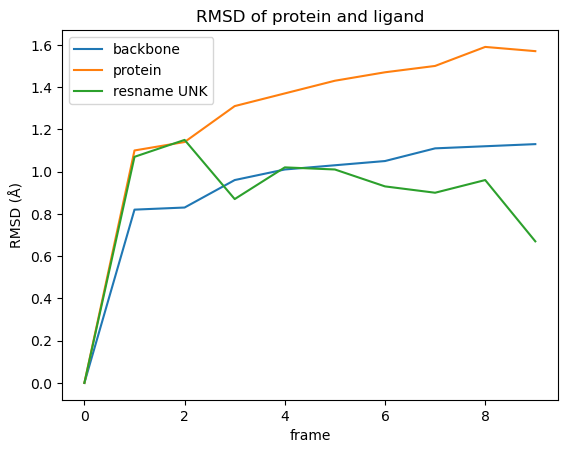

In [38]:
rmsd.plot(title="RMSD of protein and ligand")
plt.ylabel("RMSD (Å)");